<a href="https://colab.research.google.com/github/meet21039/EEE-GS-513--Machine-Learning-Course-Project/blob/main/MRI_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, random, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from sklearn.metrics import classification_report, confusion_matrix

# --- Configuration ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Set reproducibility seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# Load training and testing sets
train_dir = os.path.join("/content/drive/MyDrive/MRI/Training")
test_dir = os.path.join("/content/drive/MyDrive/MRITest/Testing")

# Load full training dataset first
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int"  # ✅ integer labels 0–3
)

# Save class names before splitting
class_names = full_train_ds.class_names
print("Detected classes:", class_names)

# Create validation split (20%)
val_size = 0.2
train_size = int((1 - val_size) * tf.data.experimental.cardinality(full_train_ds).numpy())
train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int"
)


Found 5712 files belonging to 4 classes.
Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 1311 files belonging to 4 classes.


In [ ]:
# Normalize and augment images
normalizer = layers.Rescaling(1./255)
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
])

def preprocess(x, y, augment_flag=False):
    x = normalizer(x)
    if augment_flag:
        x = augment(x)
    return x, y

train_ds = train_ds.map(lambda x, y: preprocess(x, y, True), num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# Optimize data loading
train_ds = train_ds.shuffle(1000).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


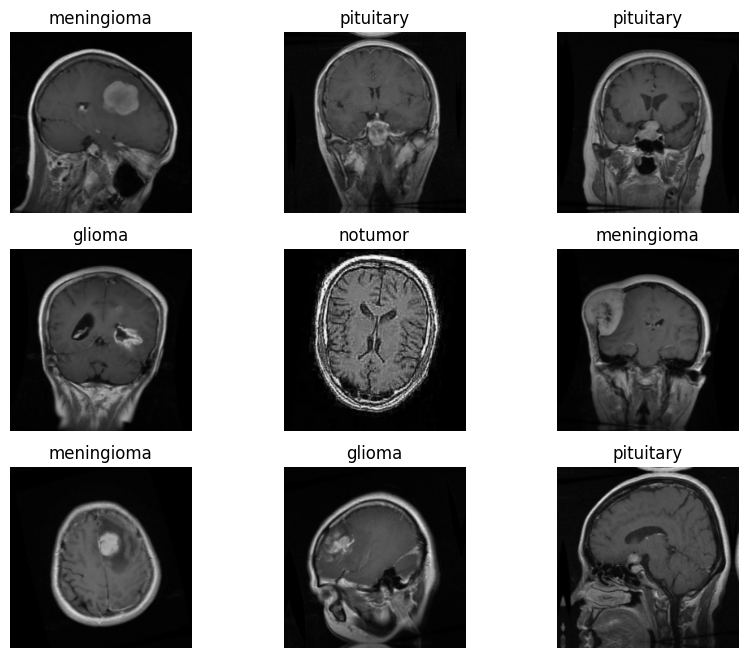

In [ ]:
# View 9 random samples from training data
plt.figure(figsize=(10,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [ ]:
for x, y in train_ds.take(1):
    print("Images batch shape:", x.shape)
    print("Labels batch shape:", y.shape)
    print("Sample labels:", y[:10].numpy())


In [ ]:
# Simple CNN for initial training
def make_baseline_cnn(input_shape=IMG_SIZE + (3,), num_classes=len(class_names)):
    model = keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = make_baseline_cnn()
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,764 (366.27 KB)

 Trainable params: 93,764 (366.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save best model weights
checkpoint_path = "/content/drive/MyDrive/MRI/mri_baseline_best.keras"
cbs = [
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs
)


Epoch 1/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3150 - loss: 1.3076
Epoch 1: val_accuracy improved from -inf to 0.51585, saving model to /content/drive/MyDrive/MRI/mri_baseline_best.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.3162 - loss: 1.3065 - val_accuracy: 0.5158 - val_loss: 1.0018
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5444 - loss: 1.0651
Epoch 2: val_accuracy did not improve from 0.51585
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5446 - loss: 1.0649 - val_accuracy: 0.5106 - val_loss: 1.0316
Epoch 3/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6065 - loss: 0.9505
Epoch 3: val_accuracy did not improve from 0.51585
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6066 - loss: 0.9504 - val_accuracy: 0.4886 - val_loss: 1.1285
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6472 - loss: 0.8864
Epoch 4: val_accuracy did not improve from 0.51585
143/143 ━━━━━━━━━━━━━━━━━

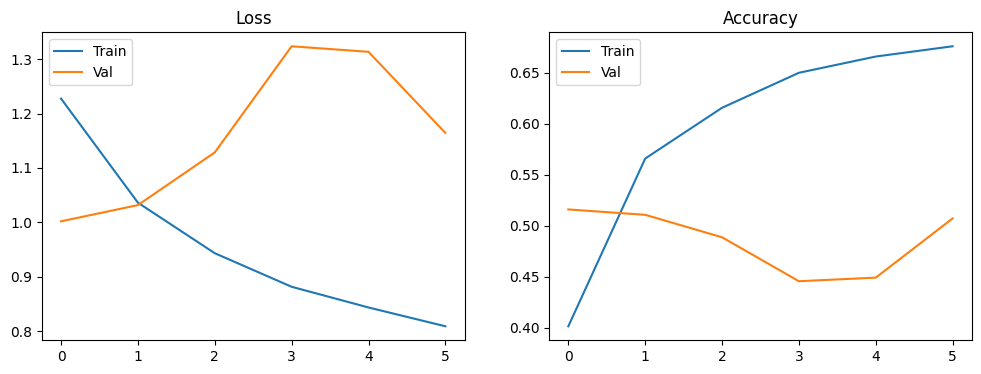

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.show()
plt.savefig("/content/drive/MyDrive/MRI/Accuracy.png")


In [ ]:
model.load_weights(checkpoint_path)

test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.3f}, Loss: {test_loss:.3f}")

# Predictions
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))




41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.4375 - loss: 1.1790

✅ Test Accuracy: 0.444, Loss: 1.159
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.64      0.46      0.54       300
  meningioma       0.30      0.36      0.33       306
     notumor       0.45      0.74      0.56       405
   pituitary       0.49      0.11      0.18       300

    accuracy                           0.44      1311
   macro avg       0.47      0.42      0.40      1311
weighted avg       0.47      0.44      0.42      1311

Confusion Matrix:
[[139 129  29   3]
 [ 51 110 132  13]
 [ 21  66 299  19]
 [  5  56 205  34]]


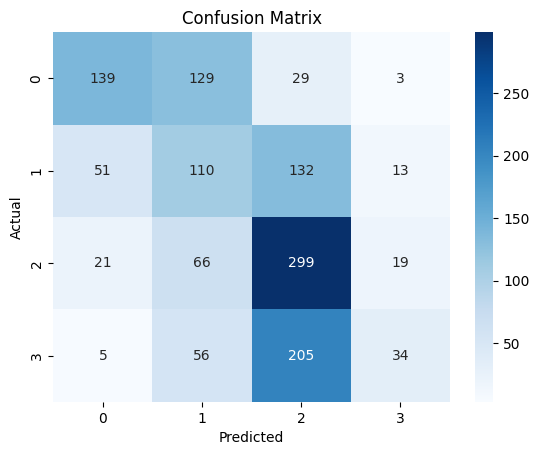

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
cm=confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("/content/drive/MyDrive/MRI/confusion_matrix.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import label_binarize
NUM_CLASSES=4
MODEL_SAVE_PATH="/content/drive/MyDrive/MRI/mri_baseline_best.keras"
base = keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
base.trainable = False  # transfer phase: freeze base

inp = layers.Input(shape=IMG_SIZE + (3,))
x = base(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inp, out, name='EffNetB0_TL')

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

class ValAUCCallback(callbacks.Callback):
    def __init__(self, val_ds, class_names):
        super().__init__()
        self.val_ds = val_ds
        self.class_names = class_names
        self.num_classes = len(class_names)

    def on_epoch_end(self, epoch, logs=None):
        # gather all val labels & probs
        y_true = np.concatenate([y.numpy() for x, y in self.val_ds], axis=0)
        y_prob = self.model.predict(self.val_ds, verbose=0)
        # binarize true labels
        y_true_oh = label_binarize(y_true, classes=list(range(self.num_classes)))
        try:
            per_class_auc = roc_auc_score(y_true_oh, y_prob, average=None)
            macro_auc = roc_auc_score(y_true_oh, y_prob, average='macro')
        except Exception as e:
            print("Could not compute AUC:", e)
            return
        # log & print
        print(f"\nEpoch {epoch+1} validation AUC per class: {dict(zip(self.class_names, np.round(per_class_auc,4)))}")
        print(f"Epoch {epoch+1} validation Macro AUC: {macro_auc:.4f}")

val_auc_cb = ValAUCCallback(val_ds=val_ds, class_names=class_names)

checkpoint_cb = callbacks.ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb  = callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

# 7) Train — transfer stage
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=[checkpoint_cb, earlystop_cb, val_auc_cb]
)

Model: "EffNetB0_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6038 - loss: 0.9553Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 153s 854ms/step - accuracy: 0.6046 - loss: 0.9537 - val_accuracy: 0.8574 - val_loss: 0.4431
Epoch 2/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8215 - loss: 0.4724Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 614ms/step - accuracy: 0.8216 - loss: 0.4723 - val_accuracy: 0.8847 - val_loss: 0.3560
Epoch 3/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8509 - loss: 0.3906Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 630ms/step - accuracy: 0.8509 - loss: 0.3906 - val_accuracy: 0.8979 - val_loss: 0.3204
Epoch 4/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8768 - loss: 0.3455Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 107s 751ms/step - accuracy: 0.

In [ ]:
base.trainable = True
# freeze all but last 20 layers
for layer in base.layers[:-20]:
    layer.trainable = False

# recompile with lower LR and only accuracy metric
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

checkpoint_cb2 = callbacks.ModelCheckpoint(MODEL_SAVE_PATH.replace(".keras", "_finetuned.keras"),
                                           save_best_only=True, monitor='val_accuracy', mode='max')

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[checkpoint_cb2, earlystop_cb, val_auc_cb]
)


Epoch 1/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7670 - loss: 0.6369Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 147s 834ms/step - accuracy: 0.7673 - loss: 0.6363 - val_accuracy: 0.8776 - val_loss: 0.3228
Epoch 2/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8501 - loss: 0.4435Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 629ms/step - accuracy: 0.8502 - loss: 0.4434 - val_accuracy: 0.8882 - val_loss: 0.3169
Epoch 3/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8624 - loss: 0.3816Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 627ms/step - accuracy: 0.8624 - loss: 0.3816 - val_accuracy: 0.8838 - val_loss: 0.3083
Epoch 4/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8768 - loss: 0.3490Could not compute AUC: name 'roc_auc_score' is not defined
143/143 ━━━━━━━━━━━━━━━━━━━━ 109s 762ms/step - accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

🔹 MODEL OUTPUT 🔹
Predicted Index: 0
Predicted Class: glioma
Confidence: 0.9954

Class probability breakdown:
  0 → glioma: 0.9954
  1 → meningioma: 0.0038
  2 → notumor: 0.0002
  3 → pituitary: 0.0006

📁 Saved final Grad-CAM to: /content/final_gradcam_highlight.png


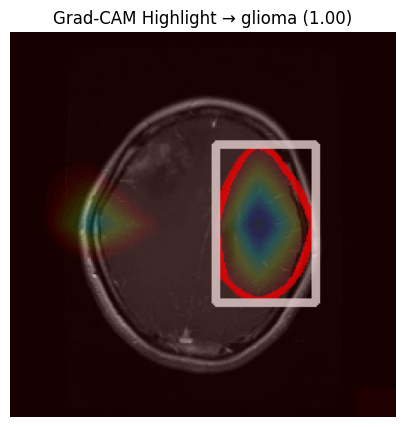

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# ---------------- DEFINE GRAD-CAM FUNCTION ----------------
def find_last_conv_in_base(base_model):
    for layer in reversed(base_model.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the base model.")

def make_gradcam_heatmap_working(img_array, full_model, pred_index=None):
    # Find nested CNN base
    base = None
    for layer in full_model.layers:
        if hasattr(layer, "layers") and len(layer.layers) > 0:
            base = layer
            break

    last_conv_name = find_last_conv_in_base(base)
    last_conv = base.get_layer(last_conv_name)

    conv_model = tf.keras.Model(inputs=base.input, outputs=last_conv.output)

    img_tensor = tf.cast(img_array, tf.float32)
    conv_outs = conv_model(img_tensor, training=False)

    # Forward through model head manually
    base_idx = [i for i, l in enumerate(full_model.layers) if l is base][0]

    x = conv_outs
    for layer in full_model.layers[base_idx+1:]:
        try:
            x = layer(x, training=False)
        except:
            x = layer(x)

    preds = x

    if pred_index is None:
        pred_index = int(tf.argmax(preds[0]))

    with tf.GradientTape() as tape:
        tape.watch(conv_outs)
        x2 = conv_outs
        for layer in full_model.layers[base_idx+1:]:
            try:
                x2 = layer(x2, training=False)
            except:
                x2 = layer(x2)
        preds2 = x2
        class_score = preds2[:, pred_index]

    grads = tape.gradient(class_score, conv_outs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

    cam = np.sum(conv_outs[0].numpy() * pooled[None,None,:], axis=-1)
    cam = np.maximum(cam, 0)
    cam /= (cam.max() + 1e-8)

    heatmap = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    return heatmap

# ---------------- PARAMETERS ----------------
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
THR_PERCENTILE = 85
ALPHA_HEAT = 0.5
ALPHA_MASK = 0.65
MIN_AREA = 200
SAVE_PATH = "/content/final_gradcam_highlight.png"
sample_path = "/content/drive/MyDrive/MRITest/Testing/glioma/Te-glTr_0002.jpg"
# ---------------- INPUT IMAGE ----------------
img_bgr = cv2.imread(sample_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (IMG_SIZE[1], IMG_SIZE[0]))

img_pre = preprocess_input(img_resized.astype('float32'))
img_input = np.expand_dims(img_pre, axis=0)

# ---------------- PREDICT ----------------
preds = model.predict(img_input)
pred_idx = int(np.argmax(preds[0]))
pred_class = class_names[pred_idx]

print("\n🔹 MODEL OUTPUT 🔹")
print(f"Predicted Index: {pred_idx}")
print(f"Predicted Class: {pred_class}")
print(f"Confidence: {preds[0][pred_idx]:.4f}")

print("\nClass probability breakdown:")
for i, c in enumerate(class_names):
    print(f"  {i} → {c}: {preds[0][i]:.4f}")

# ---------------- GENERATE HEATMAP ----------------
heatmap = make_gradcam_heatmap_working(img_input, model)

# refine
hm = cv2.GaussianBlur((heatmap * 255).astype(np.uint8), (11,11), 0).astype(np.float32)/255.
thr = np.percentile(hm, THR_PERCENTILE)
hm_thr = np.clip((hm - thr) / (hm.max() - thr + 1e-8), 0, 1)

mask_uint8 = (hm_thr * 255).astype(np.uint8)
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

overlay = img_resized.copy()

if contours:
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = contours[0]

    if cv2.contourArea(cnt) > MIN_AREA:
        cv2.drawContours(overlay, [cnt], -1, (255, 0, 0), 3)
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay, (x,y), (x+w,y+h), (255,255,255), 4)

heatmap_color = cv2.applyColorMap((hm_thr*255).astype(np.uint8), cv2.COLORMAP_JET)
blended = cv2.addWeighted(img_resized, 1-ALPHA_HEAT, heatmap_color, ALPHA_HEAT, 0)

# ---------------- SAVE & DISPLAY ----------------
final = cv2.addWeighted(blended, 1-ALPHA_MASK, overlay, ALPHA_MASK, 0)

plt.figure(figsize=(10,5))
plt.imshow(final)
plt.axis('off')
plt.title(f"Grad-CAM Highlight → {pred_class} ({preds[0][pred_idx]:.2f})")

cv2.imwrite(SAVE_PATH, cv2.cvtColor(final, cv2.COLOR_RGB2BGR))
print(f"\n📁 Saved final Grad-CAM to: {SAVE_PATH}")
